### 2D ray optics example with smooth index-of-refraction field $n(x,y)$

Rays are followed through a medium with a space varying index of refraction $n(x,y)$. Each ray is traced using a generic ODE solver. The result is visually compared to the classic *Snell's law* where the interface is a smooth sigmoid step instead of a hard discontinuous interface. In what follows the respective refractory indices for air, glass, and water are $1.00$, $1.50$, and $1.33$.

In [1]:
import numpy as np
import scipy.integrate as scintegr
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)

### Basic equations
The ray tracer in this notebook integrates the state $$\mathbf{A}=\left(s,x,y,p_x,p_y,a\right)$$ where $$p_x=n\frac{dx}{ds}$$ and $$p_y=n\frac{dy}{ds}$$ and $s$ is the arclength parameter and $a$ is the cumulative action integral (see below). 

The ray path ODE is $$\frac{d\mathbf{A}}{ds}=\left(1,\frac{p_x}{n},\frac{p_y}{n},\frac{\partial n}{\partial x}, \frac{\partial n}{\partial y},n\right)$$ An invariant of this system is $$p_x^2+p_y^2=n^2$$  The ray is initialized with a location $(x,y)$ and a orientation $$p_x=n(x,y)\cos\phi$$ $$p_y=n(x,y)\sin\phi$$ for some initial ray angle $\phi$. It further holds $p_x^2-p_y^2 = n^2\cos 2\phi$.

The state $\mathbf{A}$ is not minimal. It would be possible to describe the 2D ray with a smaller state $(x,y,\phi)$.

#### Stationary action integral
The above ray tracing equations come from the following action integral $$\mathcal{A} = \int\mathrm{dl}\;\mathcal{L}\left(x,y,x^{\prime},y^{\prime}\right) = \int\mathrm{dl}\;n\left(x(l), y(l)\right) \sqrt{(x^{\prime})^2 + (y^{\prime})^2} = \int \mathrm{ds}\;n $$ where $x^{\prime}$ (and $y^{\prime}$) denotes derivative w.r.t. a line parametrization $l$. Note that $n=c/v$ where $c$ is the speed of light in vacuum and $v$ is the speed of light in the medium. This integral corresponds to the total time spent on the ray path (divide integral value by the speed of light: $T = \mathcal{A}/c$). The *Euler-Lagrange* equations can be put on the form $$\frac{d}{ds}\left(n\frac{dx}{ds}\right) = \frac{\partial n}{\partial x}$$ with an identical equation for $y$. The above equation is sometimes known as the *Eikonal equation in Ray Optics*. Both the 2D and 3D versions look like this $$\frac{d}{ds}\left(n\frac{d\mathbf{r}}{ds}\right) = \nabla n$$ but there are many alternative formulations. Notice that this version is *isotropic* since $n$ does not depend on the direction of the ray, only its location in space.

In [2]:
# Basic air-glass interface at x=0, parametrized by a sigmoid
def index_interface_at_x_eq_zero(x, y, nleft = 1.00, nright = 1.50, L = 0.05):
    z = np.exp(-x / L)
    value = nleft + (nright - nleft) * 1 / (1 + z)
    gradx = (nright - nleft) * z / ((1 + z) ** 2) / L
    grady = 0.0 * z
    return value, gradx, grady

In [3]:
# Sanity check of smooth step of index of refraction along x
xvec = np.linspace(-1, 1, 10000)
v, gx, gy = index_interface_at_x_eq_zero(xvec, 0.0)

v_check = v[0] + np.hstack([0.0, scintegr.cumtrapz(gx, xvec)])
err_check = np.max(np.abs(v - v_check)) 
assert err_check < 1e-6

In [4]:
# Basic ODE function for the smooth air-glass transition
def rayfunc1(A, t, refrfunc = index_interface_at_x_eq_zero):
    assert A.size == 6
    #s = A[0]
    x = A[1]
    y = A[2]
    px = A[3]
    py = A[4]
    #a = A[5]
    n, dnx, dny = refrfunc(x, y)
    return np.array([1.0, px / n, py / n, dnx, dny, n])

ode_rtol = 1.0e-9
ode_atol = 1.0e-9

#### Launch rays from air into glass

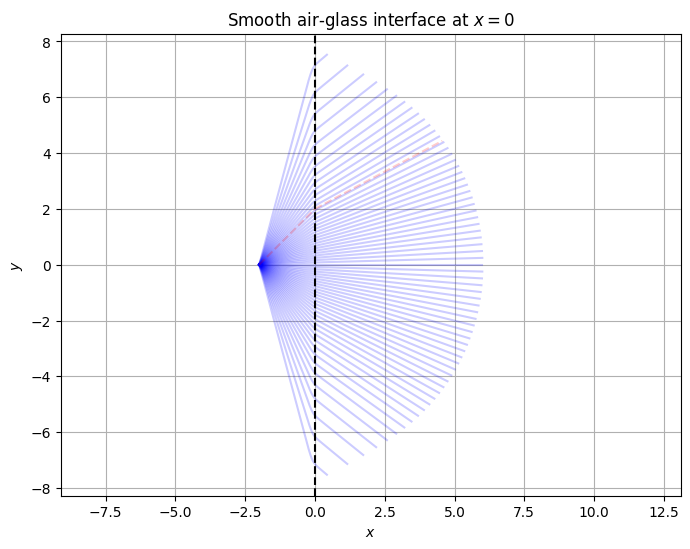

In [5]:
#%matplotlib notebook

x0 = -2.0
y0 = 0.0
n0, _, _ = index_interface_at_x_eq_zero(x0, y0)
svec = np.linspace(0.0, 8.0, 1001)

for deg in np.linspace(-75.0, 75.0, 65):
    phi0 = deg * np.pi / 180.0
    A0 = np.array([0.0, x0, y0, n0 * np.cos(phi0), n0 * np.sin(phi0), 0.0])
    sol = scintegr.odeint(rayfunc1, A0, svec, full_output = 1, atol = ode_atol, rtol = ode_rtol)
    A = sol[0]
    assert A.shape[0] == svec.size and A.shape[1] == A0.size 
    assert np.isclose(A[-1, 0], svec[-1])
    plt.plot(A[:, 1], A[:, 2], c = 'b', alpha = 0.20)

# Overlay Snell's law at a particular angle
n1 = 1.00
n2 = 1.50
theta1 = 45.0 * np.pi / 180.0
theta2 = np.arcsin((n1 / n2) * np.sin(theta1))
d = -x0
h = d * np.tan(theta1)
l1 = d * np.sqrt(1 + np.tan(theta1) ** 2)
l2 = svec[-1] - l1
p2 = [0 + l2 * np.cos(theta2), h + l2 * np.sin(theta2)]
plt.plot([x0, 0], [y0, h], c = 'r', linestyle = '--', alpha = 0.20)
plt.plot([0, p2[0]], [h, p2[1]], c = 'r', linestyle = '--', alpha = 0.20)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.axvline(x = 0.0, c = 'k', linestyle = '--')
plt.title('Smooth air-glass interface at $x=0$')
plt.show()


#### Launch rays from glass into air

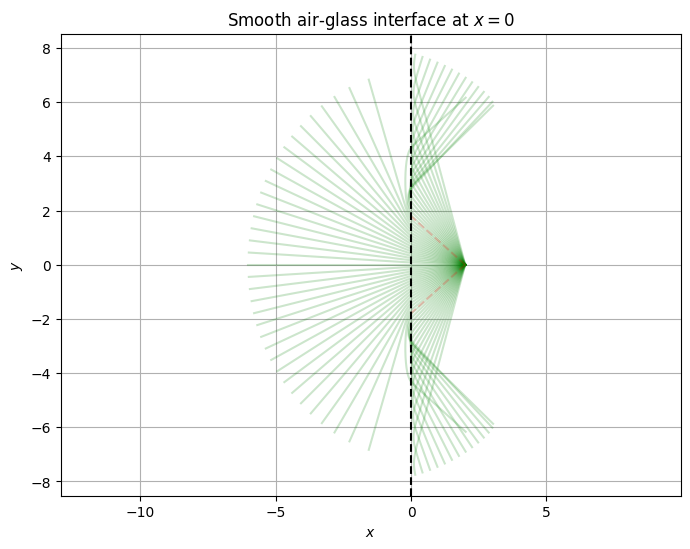

In [6]:
#%matplotlib notebook

x0 = 2.0
y0 = 0.0
n0, _, _ = index_interface_at_x_eq_zero(x0, y0)
svec = np.linspace(0.0, 8.0, 1001)

for deg in np.linspace(-75.0, 75.0, 65):
    phi0 = (deg + 180.0) * np.pi / 180.0
    A0 = np.array([0.0, x0, y0, n0 * np.cos(phi0), n0 * np.sin(phi0), 0.0])
    sol = scintegr.odeint(rayfunc1, A0, svec, full_output = 1, atol = ode_atol, rtol = ode_rtol)
    A = sol[0]
    assert A.shape[0] == svec.size and A.shape[1] == A0.size 
    assert np.isclose(A[-1, 0], svec[-1])
    plt.plot(A[:, 1], A[:, 2], c = 'g', alpha = 0.20)

# Overlay the hard-interface critical angle cone
theta2_crit = np.arcsin(n1 / n2)
h = x0 * np.tan(theta2_crit)
plt.plot([x0, 0], [y0, h], c = 'r', linestyle = '--', alpha = 0.20)
plt.plot([x0, 0], [y0, -h], c = 'r', linestyle = '--', alpha = 0.20)
    
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.axvline(x = 0.0, c = 'k', linestyle = '--')
plt.title('Smooth air-glass interface at $x=0$')
plt.show()


### Air-glass-air vs. air-glass-water (circular domain)

In [7]:
def cubic_transition_coefs(n1, n2, r1, d):
    A = np.array([[1.0, r1 - d, (r1 - d) ** 2, (r1 - d) ** 3],
                  [1.0, r1 + d, (r1 + d) ** 2, (r1 + d) ** 3],
                  [0.0, 1.0, 2 * (r1 - d), 3 * (r1 - d) ** 2],
                  [0.0, 1.0, 2 * (r1 + d), 3 * (r1 + d) ** 2]])
    c = np.linalg.solve(A, np.array([n1, n2, 0.0, 0.0]))
    return c

def cubic_transition_funct(r, coefs):
    f = coefs[0] + coefs[1] * r + coefs[2] * r ** 2 + coefs[3] * r ** 3
    df = coefs[1] + 2 * coefs[2] * r + 3 * coefs[3] * r ** 2
    return f, df

def make_param_dict(n1, n2, n3, R1 = 2.00, R2 = 2.10, tw = 0.03):
    return {'n1' : n1,
            'n2' : n2,
            'n3' : n3,
            'R1' : R1,
            'R2' : R2,
            'tw' : tw,
            'c1' : cubic_transition_coefs(n1, n2, R1, tw),
            'c2' : cubic_transition_coefs(n2, n3, R2, tw) }

params_with_water = make_param_dict(1.33, 1.50, 1.00)
params_without_water = make_param_dict(1.00, 1.50, 1.00)

# Circular structure centered at the origin with three domains: inner, middle, and outer
# Not vectorized
def radial_index_triad(x, y, P):
    r = np.sqrt(x ** 2 + y ** 2)
    if r == 0.0:
        return n1, 0.0, 0.0
    
    cs = x / r
    sn = y / r
    
    tw = P['tw']
    R1 = P['R1']
    R2 = P['R2']
    
    if r < R1 - tw:
        f = P['n1']
        df = 0.0
    elif r >= R1 - tw and r < R1 + tw:
        f, df = cubic_transition_funct(r, P['c1'])
    elif r >= R1 + tw and r < R2 - tw:
        f = P['n2']
        df = 0.0
    elif r >= R2 - tw and r < R2 + tw:
        f, df = cubic_transition_funct(r, P['c2'])
    else:
        f = P['n3']
        df = 0.0
 
    return f, df * cs, df * sn

def rayfunc_with_water(A, t):
    def local(x, y):
        return radial_index_triad(x, y, params_with_water)
    return rayfunc1(A, t, refrfunc = local)

def rayfunc_without_water(A, t):
    def local(x, y):
        return radial_index_triad(x, y, params_without_water)
    return rayfunc1(A, t, refrfunc = local)


#### Ray trace with *no* water inside circular domain with thick glass boundary

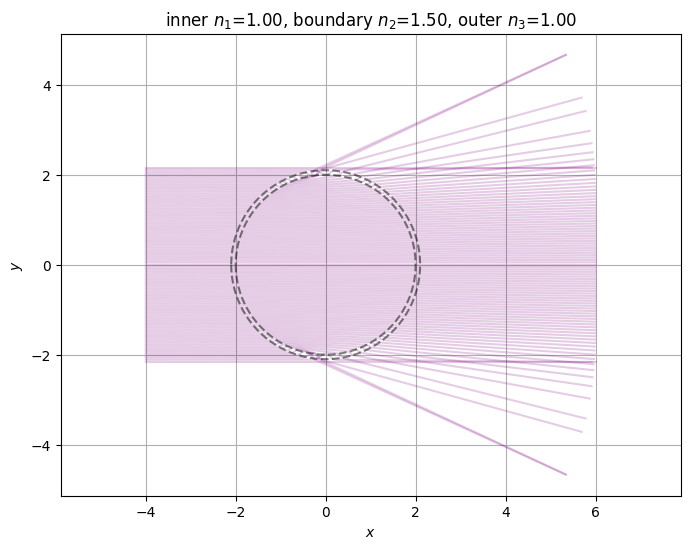

In [8]:
#%matplotlib notebook

Nrays = 91
svec = np.linspace(0.0, 10.0, 1001)

for y0 in np.linspace(-params_without_water['R2'] - 2 * params_without_water['tw'], 
                      params_without_water['R2'] + 2 * params_without_water['tw'], Nrays):
    phi0 = 0.0
    x0 = -4.0
    n0, _, _ = radial_index_triad(x0, y0, params_without_water)
    A0 = np.array([0.0, x0, y0, n0 * np.cos(phi0), n0 * np.sin(phi0), 0.0])
    sol = scintegr.odeint(rayfunc_without_water, A0, svec, 
                          full_output = 1, atol = ode_atol, rtol = ode_rtol, 
                          hmax = params_without_water['tw'] / 10)
    A = sol[0]
    assert A.shape[0] == svec.size and A.shape[1] == A0.size 
    assert np.isclose(A[-1, 0], svec[-1])
    plt.plot(A[:, 1], A[:, 2], c = 'purple', alpha = 0.20)

thvec = np.linspace(-np.pi, np.pi, 200)
plt.plot(params_without_water['R1'] * np.cos(thvec), params_without_water['R1'] * np.sin(thvec), 
         c = 'k', linestyle = '--', alpha = 0.50)
plt.plot(params_without_water['R2'] * np.cos(thvec), params_without_water['R2'] * np.sin(thvec), 
         c = 'k', linestyle = '--', alpha = 0.50)
    
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.title('inner $n_1$={:.2f}, boundary $n_2$={:.2f}, outer $n_3$={:.2f}'.format(
    params_without_water['n1'], params_without_water['n2'], params_without_water['n3']))
plt.show()


#### Ray trace *with* water inside circular domain with thick glass boundary

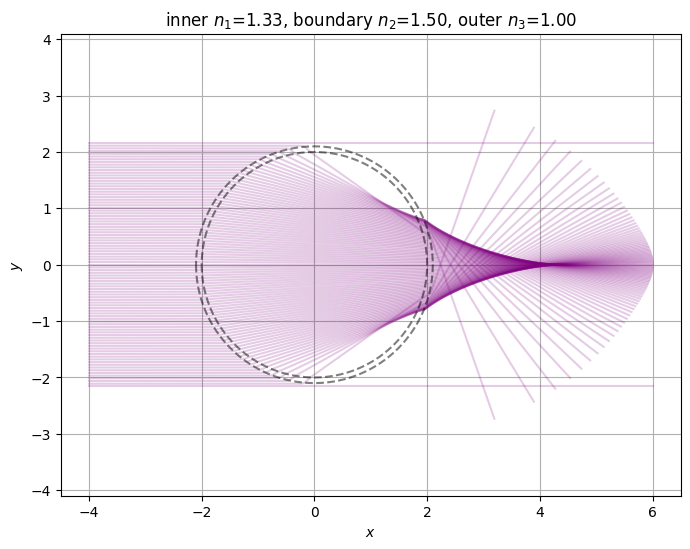

In [9]:
#%matplotlib notebook

Nrays = 91
svec = np.linspace(0.0, 10.0, 1001)

for y0 in np.linspace(-params_with_water['R2'] - 2 * params_with_water['tw'], 
                      params_with_water['R2'] + 2 * params_with_water['tw'], Nrays):
    phi0 = 0.0
    x0 = -4.0
    n0, _, _ = radial_index_triad(x0, y0, params_with_water)
    A0 = np.array([0.0, x0, y0, n0 * np.cos(phi0), n0 * np.sin(phi0), 0.0])
    sol = scintegr.odeint(rayfunc_with_water, A0, svec, 
                          full_output = 1, atol = ode_atol, rtol = ode_rtol, 
                          hmax = params_with_water['tw'] / 10)
    A = sol[0]
    assert A.shape[0] == svec.size and A.shape[1] == A0.size 
    assert np.isclose(A[-1, 0], svec[-1])
    plt.plot(A[:, 1], A[:, 2], c = 'purple', alpha = 0.20)

thvec = np.linspace(-np.pi, np.pi, 200)
plt.plot(params_with_water['R1'] * np.cos(thvec), params_with_water['R1'] * np.sin(thvec), 
         c = 'k', linestyle = '--', alpha = 0.50)
plt.plot(params_with_water['R2'] * np.cos(thvec), params_with_water['R2'] * np.sin(thvec), 
         c = 'k', linestyle = '--', alpha = 0.50)
    
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.title('inner $n_1$={:.2f}, boundary $n_2$={:.2f}, outer $n_3$={:.2f}'.format(
    params_with_water['n1'], params_with_water['n2'], params_with_water['n3']))
plt.show()


### Optical orbit example

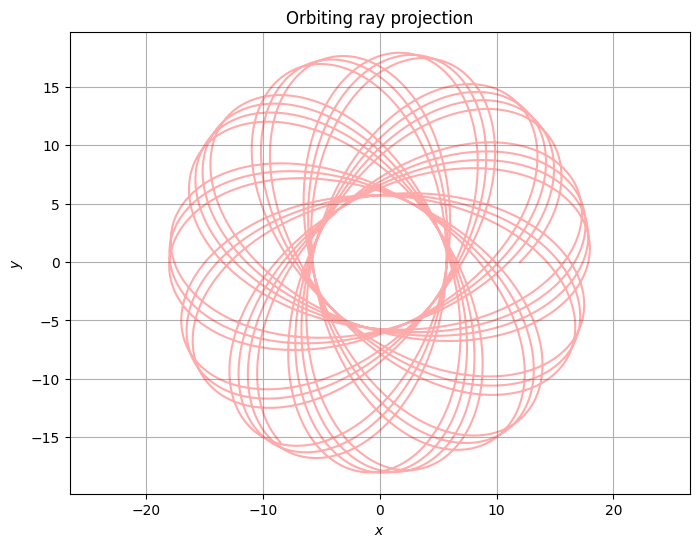

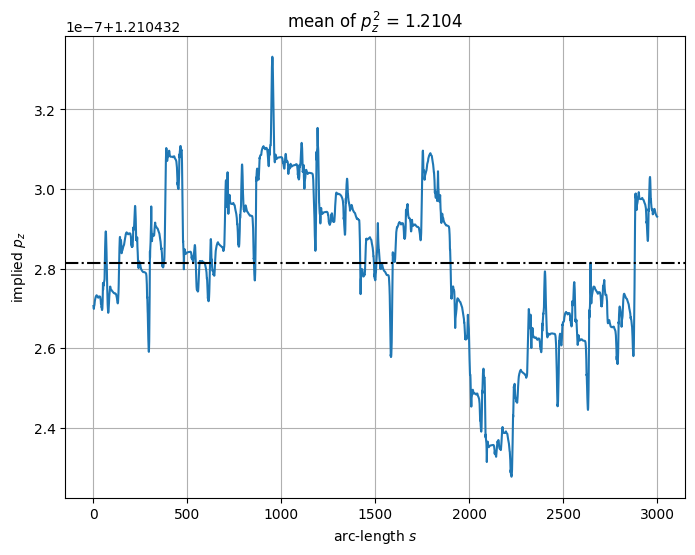

In [10]:
def gaussian_n(x, y, sig = 10):
    rsq = x * x + y * y
    xi = rsq / (2 * sig ** 2)
    n = 1 + np.exp(-xi)
    nx = (- x / sig ** 2) * np.exp(-xi)
    ny = (- y / sig ** 2) * np.exp(-xi)
    return n, nx, ny

def rayfunc_gaussian(A, t):
    return rayfunc1(A, t, refrfunc = gaussian_n)

# NOTE: initial momentum does not satisfy the px^2 + py^2 = n^2 relationship
#       if it does; the path does not orbit the origin!
#
#       instead think of the motion being a 2D projection of a 3D ray
#       where: px^2 + py^2 + pz^2 = n^2, or
#              px^2 + py^2 = n^2 - pz^2 < n^2, and pz = constant
#
#       verify that the implied pz is a constant
#

x0 = 12.0
y0 = 0.0
n0 = 1.0 # n0, _, _ = gaussian_n(x0, y0)
v1 = 0.707
v2 = np.sqrt(1 - v1 ** 2)
A0 = np.array([0.0, x0, y0, n0 * v1, n0 * v2, 0.0])

svec = np.linspace(0.0, 3000.0, 10000)
sol = scintegr.odeint(rayfunc_gaussian, A0, svec, 
                      full_output = 1, atol = ode_atol, rtol = ode_rtol)
A = sol[0]
assert A.shape[0] == svec.size and A.shape[1] == A0.size 
assert np.isclose(A[-1, 0], svec[-1])

plt.plot(A[:, 1], A[:, 2], c = 'r', alpha = 0.33)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.axis('equal')
plt.title('Orbiting ray projection')
plt.show()

ntraj, _, _ = gaussian_n(A[:, 1], A[:, 2])
pzsq = -1 * (A[:, 3] ** 2 + A[:, 4] ** 2 - ntraj ** 2)
avgpzsq = np.mean(pzsq)

plt.plot(A[:, 0], pzsq)
plt.axhline(y = avgpzsq, c = 'k', linestyle = '-.')
plt.xlabel('arc-length $s$')
plt.ylabel('implied $p_z$')
plt.grid(True)
plt.title('mean of $p_z^2$ = {:.4f}'.format(avgpzsq))
plt.show()

### Recommended reading
- https://galileo-unbound.blog/2019/05/30/the-iconic-eikonal-and-the-optical-path/
- https://www.fields.utoronto.ca/programs/scientific/12-13/Marsden/FieldsSS2-FinalSlidesJuly2012.pdf
